In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import OrderedDict

import pandas as pd
import seaborn as sns

from tqdm import tqdm

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_cuda_device_or_cpu():
  if torch.cuda.is_available():
    cuda_count = torch.cuda.device_count()
    
    no = 0
    mem_available = 0

    for i in range(cuda_count):
      tmp_available = torch.cuda.mem_get_info(i)[0]
      if mem_available < tmp_available:
        no = i
        mem_available = tmp_available
    return f'cuda:{no}'
  return 'cpu'

device = get_cuda_device_or_cpu()
device

'cuda:0'

In [127]:
def get_model(dim_z: int, batch_size=128, less_than=10):

  # Download training data from open datasets.
  training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
  )

  training_data.data = training_data.data[training_data.targets < less_than]
  training_data.targets = training_data.targets[training_data.targets < less_than]

  # Create data loaders.
  dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

  encoder = nn.Sequential(
    nn.Linear(784+dim_z-2, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 64),
    nn.Tanh(),
    nn.Linear(64, 2),
  )

  decoder = nn.Sequential(
    nn.Linear(dim_z, 64),
    nn.Tanh(),
    nn.Linear(64, 128),
    nn.Tanh(),
    nn.Linear(128, 512),
    nn.Tanh(),
    nn.Linear(512, 784),
    nn.Sigmoid(),
  )

  model = nn.Sequential(OrderedDict([
            ('encoder', encoder),
            ('decoder', decoder),
          ]))

  optimizer = torch.optim.Adam(model.parameters())

  return model, dataloader, optimizer

In [128]:
def train(model, dataloader, optimizer, run, epochs=5):
  
  device = get_cuda_device_or_cpu()
  
  model.to(device)
  model.train()

  hist = torch.zeros(0)

  for _ in tqdm(range(epochs)):
    tmp = run(model, dataloader, optimizer)
    hist = torch.cat([hist, tmp])
  
  return hist

In [133]:
def run_un(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  # ps = torch.tensor([[0, 0], [1, 0], [0.5, 3**0.5/2]]).to(device)
  # ps = torch.tensor([[0, 0]]).to(device)
  ps = torch.zeros(2).view(-1, 2).to(device)

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    # x = x.view([-1, 28*28]).to(device)
    x_in = x.reshape([-1, 28*28]).to(device)
    y = y.to(device)
    idx = F.one_hot(y, num_classes=10)
    x_in = torch.cat([x_in, idx], dim=1)
    x, x_in = x.view([-1, 28*28]).to(device), x_in.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x_in)
    z_0 = h[:, :2]
    # pred_vals = h[:, 2:]
    # pred_probs = F.softmax(pred_vals, dim=1)
    # pred_max = pred_probs.argmax(dim=1)
    # labels = pred_labels.argmax(dim=1)
    # idx = F.one_hot(labels, num_classes=3)

    # class_prob = (pred_labels + 1e-6)/pred_labels.sum(dim=1).view(-1, 1)
    # class_prob = F.softmax(pred_labels, dim=1)
    # alpha = (1/((1/class_prob).sum(dim=1)) + 1)
    # idx = F.one_hot(y, num_classes=10)
    z = torch.cat([z_0, idx], dim=1)

    dist = (z_0 - ps).square().sum(dim=1).mean()
    pred = model.get_submodule('decoder')(z)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1]).mean()
    # print(idx.shape)
    # print(pred_probs.shape)
    # classification = (idx*pred_probs.log() + (1 - idx)*(1 - pred_probs).log()).sum(dim=[1]).mean()
    # classification = (idx*pred_probs.log()).sum(dim=[1]).mean()
    loss = -likelihood + dist

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

100%|██████████| 30/30 [03:08<00:00,  6.27s/it]


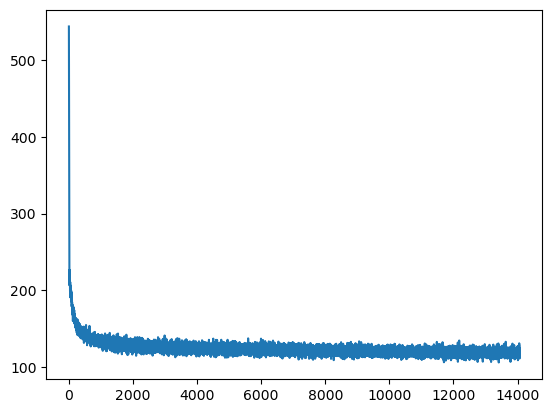

In [144]:
model, dataloader, optimizer = get_model(dim_z=12)
hist = train(model, dataloader, optimizer, run_un, 30)
plt.plot(hist)
plt.show()

<AxesSubplot:xlabel='x', ylabel='y'>

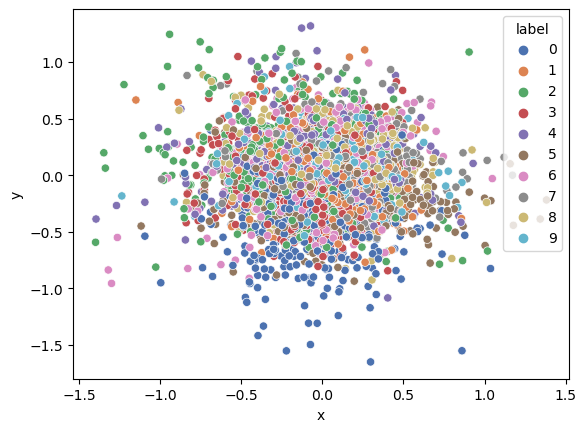

In [145]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

with torch.no_grad():
  jdx = 0
  for x, y in dataloader:
    x = x.reshape([-1, 28*28])
    x_in = x.reshape([-1, 28*28])
    idx = F.one_hot(y, num_classes=10)
    x_in = torch.cat([x_in, idx], dim=1)
    h = model.get_submodule('encoder')(x_in)
    z = h[:, :2]
    
    tmp = pd.DataFrame(
      {
        'x': z[:, 0],
        'y': z[:, 1],
        'label': y
      }
    )
    df = pd.concat([df, tmp], ignore_index=True)

    jdx += 1
    if jdx > 50:
      break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

In [168]:
def showshow(iidx):
  grid_x, grid_y = torch.meshgrid(torch.linspace(-0.5, 0.5, 11), torch.linspace(-0.5, 0.5, 11), indexing='xy')
  points = torch.stack([grid_x, grid_y], dim=2)

  tmp = torch.zeros(10)
  tmp[iidx] = 1
  tmp = tmp.view(1, 1, 10)
  tmp = torch.cat([tmp]*11, dim=0)
  tmp = torch.cat([tmp]*11, dim=1)
  tmp
  points = torch.cat([points, tmp], dim=2)

  def plot_reconstructed(decoder, points):
    w = 28
    n = len(points)
    img = torch.zeros((n*w, n*w))
    for i, r in enumerate(points):
      tmps = decoder(r).view([-1, 1, 28, 28])
      for j, tmp in enumerate(tmps):
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
    plt.axis('off')
    plt.imshow(img)

  with torch.no_grad():
    plot_reconstructed(model.get_submodule('decoder'), points)
  

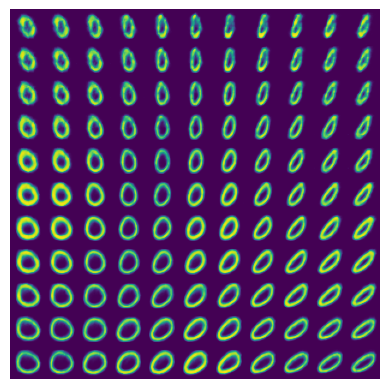

In [169]:
showshow(0)

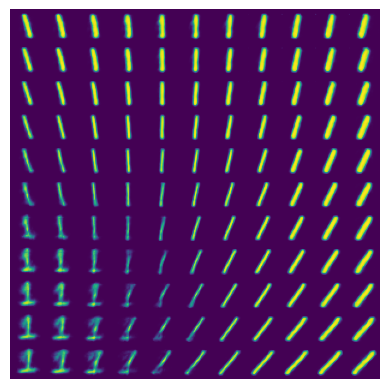

In [170]:
showshow(1)

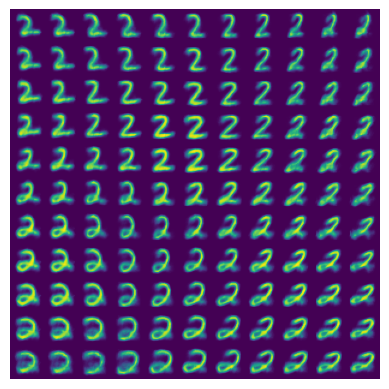

In [179]:
showshow(2)

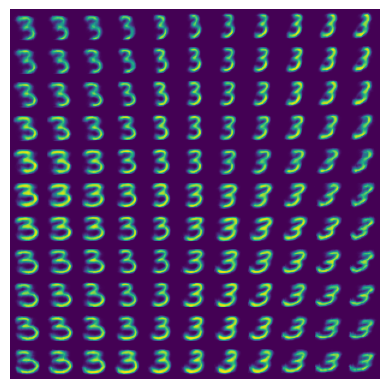

In [172]:
showshow(3)

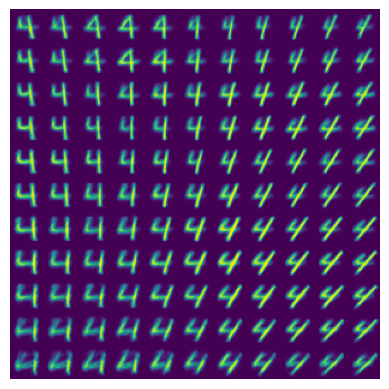

In [173]:
showshow(4)

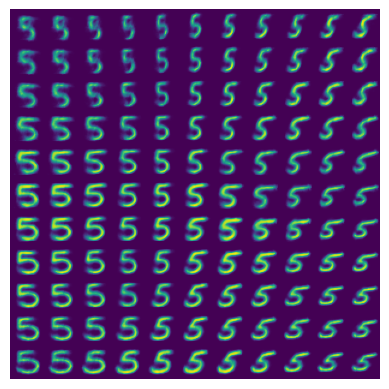

In [174]:
showshow(5)

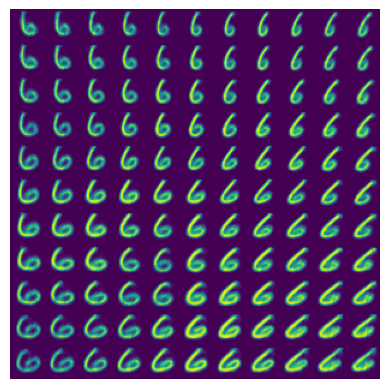

In [175]:
showshow(6)

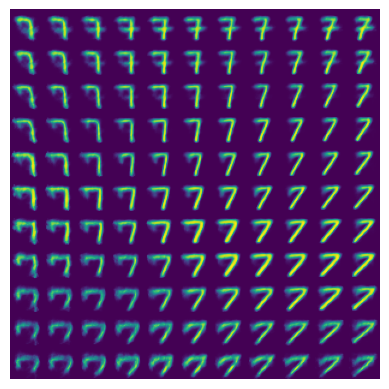

In [176]:
showshow(7)

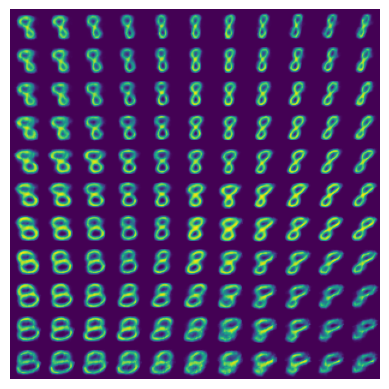

In [177]:
showshow(8)

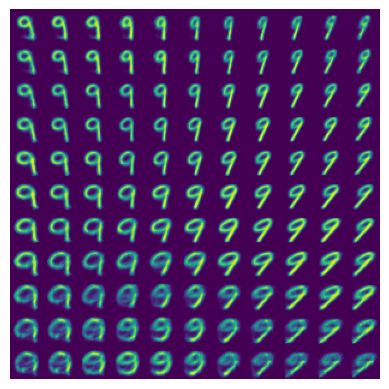

In [178]:
showshow(9)